# Module 4 - Reducing unfairness in learning algorithm applications 


### Assignment overview

In this assignment, you are tasked to create a classifer to predict the estimated income of individuals in the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). This dataset is known to be biased towards certain groups. You will try some strategies to create a more fair classifier.

For this assignment, it is possible to work in **groups of up to 2 students**. Read the instructions carefully, as they may assign tasks to specific students.

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Yanxin Liang 50798412
- Student 2: Yelia Ye 89657605


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Discuss the consequences of erroneous (biased) data on the training of learning algorithms and how it impacts its end users  
2. Discuss potential ethical implications in errors in feature selection, model selection 
3. Describe strategies for reducing algorithmic bias 
4. Apply strategies to reduce unfairness in a predictive model trained on an unbalanced dataset 
5. Describe advantages and limitations of the strategies used to reduce unfairness in predictive models

### Libraries

Here are some libraries you will need for this assignment. `imblearn` and `aif360` are new ones, you can install it by running the cell below. Comment out this line after one execution:

In [1]:
#!pip install imblearn
#!pip install aif360

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.datasets import BinaryLabelDataset
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    #plot_confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
)

import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Dataset

The dataset you will use for this assignment is the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). You may visit the source page for more information about this dataset.

The dataset includes 15 columns: 14 of them are demographics and other features to describe a person, and one (the target variable), is their income. The income variable is binary and has the two possible values `<=50K` or `>50K`.

Let's start by importing the dataset and taking a look (you are free to add other lines if you want more details):

In [3]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Unfortunately, this dataset is notoriously biased in the association between income and other demographic information, such as race and gender. Let's see how.

#### Question 1 
Create the following 3 bar charts:
- A global bar chart of the target variable
- A bar chart of the target variable divided by gender
- A bar chart of the target variable divided by race

Comment on the results. Is the target variable balanced? Is the target variable balanced across protected groups?

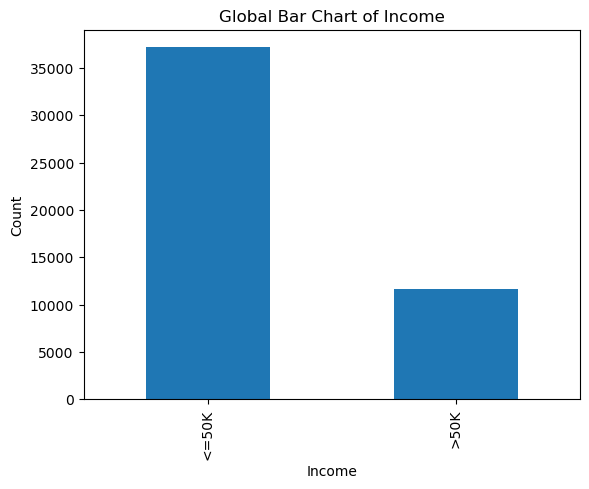

In [4]:
df['income'].value_counts().plot(kind='bar')
plt.title('Global Bar Chart of Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

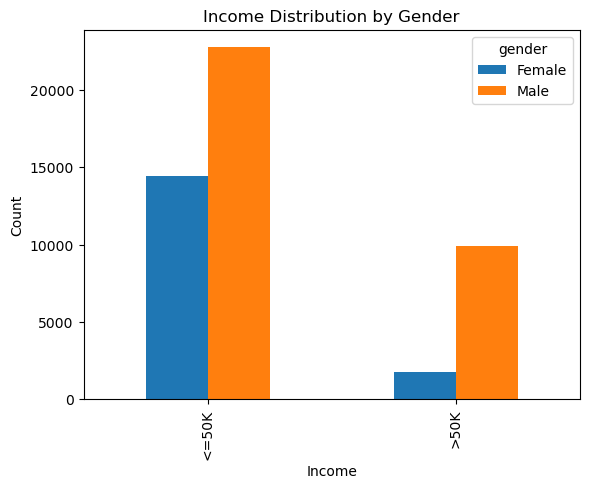

In [5]:
df.groupby(['income', 'gender']).size().unstack().plot(kind='bar')
plt.title('Income Distribution by Gender')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

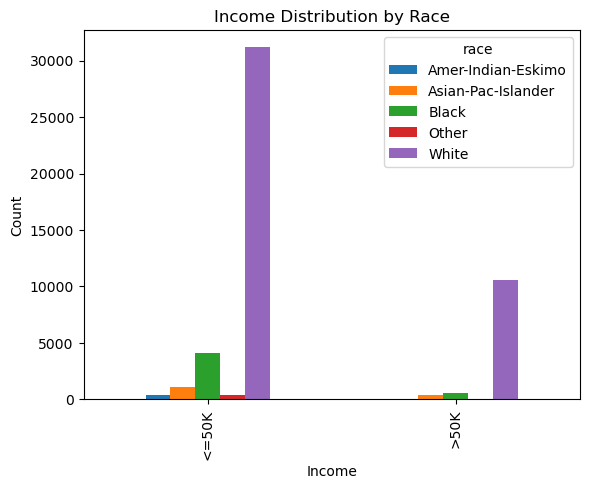

In [6]:
df.groupby(['income', 'race']).size().unstack().plot(kind='bar')
plt.title('Income Distribution by Race')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

From the first bar chart, we can clearly see that the income is imbalanced. The majority of individuals earn <=50K, with far fewer earning >50K. This imbalance indicates that the dataset could lead to biased predictions, as the model might favor predicting the majority class, which is <=50K.

When we split the income by gender, we can also see an imbalance. In class >50K, the proportions of male are much higer than female. This shows that gender might be a factor leading income inequality, and a biased predictions might be made which prefer to predict female into a lower income class.

The income distribution in different racial groups is also imbalanced. The white population dominates the dataset in both <=50K and >50K classes. In contrast, Amer-Indian-Eskimo, Asian-Pac-Islander, Black, and Other have significantly fewer data in both income categories. This bar chart shows that the minority groups are not only underrepresented but also have lower possibility to earn higher incomes. 

In conclusion, the target variable isn't balanced and it is not balanced across protected groups.

### A biased classifier

We can expect that a classifier trained on this kind of data will show some problematic behaviors when assigning an individual to a predicted income level. Let's visualize this using a random forest classifier.

In [7]:
# STEP 1
# Run this cell create training and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

In [8]:
# STEP 2
# Run this cell to do the necessary dataset preprocessing (encoding of categorical features).
# Note that, since we are using a tree based classifier, we don't need to scale the 
# numerical features.

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ct.fit_transform(X_train).toarray()

column_names = list(
    ct.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

X_test_transformed = ct.transform(X_test).toarray()

In [9]:
# You may use this lines to check the result
#pd.DataFrame(X_train_transformed, columns=column_names)
#pd.DataFrame(X_test_transformed, columns=column_names)

In [10]:
# STEP 3
# Run this cell to train a random forest classifer. The hyperparameters have been pre-selected

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_transformed, y_train)

How good is this classifier? Let's check its accuracy, by running the cells below:

In [11]:
clf.score(X_train_transformed, y_train)

0.907046125946942

In [12]:
clf.score(X_test_transformed, y_test)

0.8614618166928274

Finally, let's see what features are considered important by the classifier.

<Axes: >

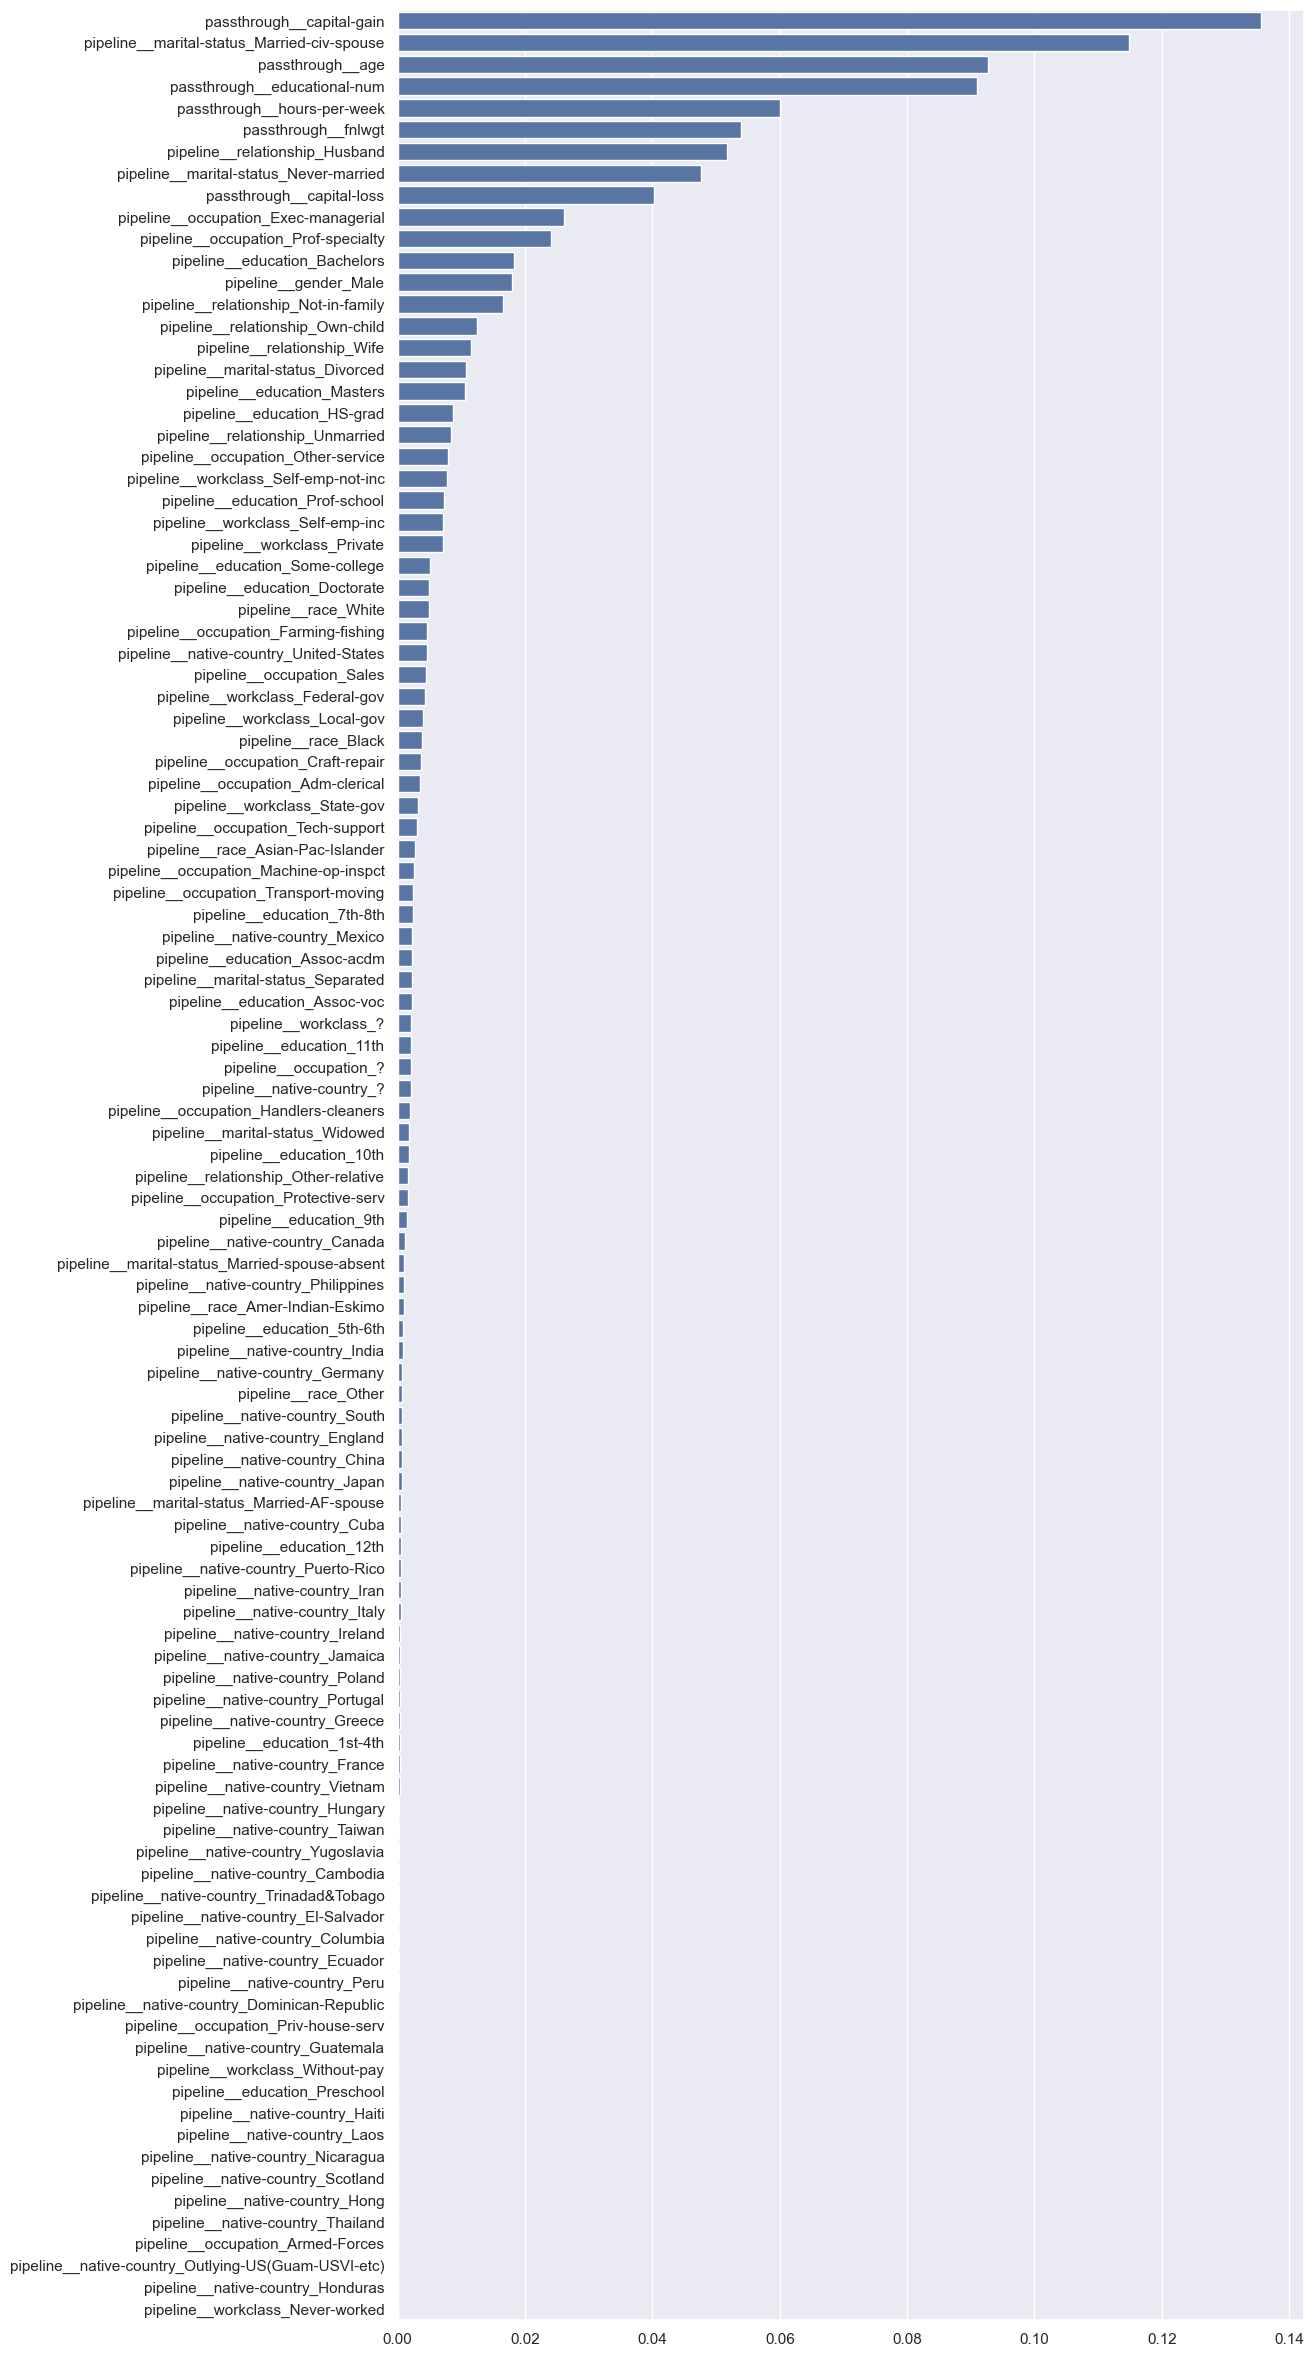

In [13]:
import seaborn as sns

feature_importances = clf.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = ct.get_feature_names_out()[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

#### Question 2
What are the most important features for this classifier? Do they include protected characteristics, such as race or gender?

The most important features are Capital-gain, Married, Age, Education, and hours-per-week in this classifier. Although Gender and Race don’t rank as high as the features mentioned before, they can still introduce bias into the prediction model. They may not directly influence predictions in a very strong way, but they might affect predictions when they combined with other features. It’s important to be mindful of these features to prevent to introduce biases into the prediction model.


#### Question 3

From Assignment 3, we have learned that a classifier may perform well in terms of accuracy, but being unfair to protected groups in the dataset. Use what you have learned in Assignment 3 and **evaluate this classifier for fairness in treating the two gender groups included in this dataset.** In particular, do the following: 

- Compute the 6 fairness metrics and the Average Distance from the Reference on training and test sets. You may reuse portions of code you have included in Assignment 3.
- Comment on the results, providing an interpretation for each computed metric; how different is the treatment of the two groups? Is one (or more) of the metrics particularly concerning?

Here is a recap of the fairness metrics:
1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

In [37]:
# Your answer here (you may add more cells)

def fairness_metrics(model,test_x,test_y,gender_exist=True,is_TEST = False):
  if gender_exist == True:
    x1 = test_x
  else:
    if is_TEST == False:
        x1 = pd.DataFrame(X_train_transformed, columns=column_names)
    else:
       x1 = pd.DataFrame(X_test_transformed, columns=column_names)

  dict={}
  pred = model.predict(test_x)


  group_female = (x1["gender_Male"] == 0.0).tolist()
  group_male = (x1["gender_Male"] == 1.0).tolist()


  cm_female = confusion_matrix(test_y[group_female], pred[group_female])
  cm_male = confusion_matrix(test_y[group_male], pred[group_male])

  TNw, FPw, FNw, TPw = cm_male.ravel()
  TNb, FPb, FNb, TPb = cm_female.ravel()

 #w represents male,  b represents female
  
  dict["PPRD"] = (TPb + FPb) / (TPw + FPw) 
  dict["PPGRD"] = ((TPb + FPb)/ (TPb + FPb + TNb + FNb)) / ((TPw + FPw) /(TPw + FPw + TNw + FNw))
  dict["FDRD"]= (FPb / (TPb + FPb))/(FPw / (TPw + FPw))
  dict["FPRD"] = (FPb / (TNb + FPb))/(FPw / (TNw + FPw))
  dict["FORD"] = (FNb / (TNb + FNb))/(FNw / (TNw + FNw)) 
  dict["FNRD"] = (FNb / (TPb + FNb))/(FNw / (TPw + FNw))


  AVG_D = sum(abs(value - 1) for value in dict.values()) / 6

  dict["Average Distance from Reference"] = AVG_D
  dict["Accuracy"] = model.score(test_x, test_y)


  metrics_df =  pd.DataFrame(list(dict.items()), columns=['Metric', 'Value'])
  return metrics_df

In [52]:
results_dict = {}

results_dict = {
 "Training_set": fairness_metrics(clf,pd.DataFrame(X_train_transformed, columns=column_names),y_train),
 "Testing_set": fairness_metrics(clf,pd.DataFrame(X_test_transformed, columns=column_names),y_test)
}

results_df = pd.concat(
    {name: result.set_index('Metric')['Value'] for name, result in results_dict.items()}, axis=1).T

results_df


Metric,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,Average Distance from Reference,Accuracy
Training_set,0.172842,0.349042,0.370874,0.101238,0.265089,0.883967,0.642825,0.907046
Testing_set,0.140122,0.281567,0.817173,0.179615,0.357543,1.237044,0.576837,0.861462



Predicted Positive Rate Difference (PPRD) calculates the ratio of the number of positive predictions between the two groups. In the training set, PPRD is 0.172842, and in the testing set, it is 0.140122. Both of the PPRD are less than 1, this shows that there exist imbalance in our prediction. This shows that the model prefer to predict the male into the class >50K than the female group. 

Predicted Positive Group Rate Disparity (PPGRD) calculates the the ratio of the positive predictions rate between the two groups. In the training set, PPGRD is 0.349042, and in the testing set, it is 0.281567. Same as what we conclude for PPRD, there is an imbalance between male and female group. The female group is predicted with a lower positive rate compared to the other group.

False Discovery Rate Disparity (FDRD) calculates the ratio of false positives (predict as >50K but actual is <=50K) rate between the two groups. In the training set, FDRD is 0.370874, and in the testing set, it is 0.817173. The results are less than 1, which means the male group has a higher rate of incorrect positive predictions.

False Positive Rate Disparity (FPRD) calculates the ratio of the proportion of false positives among all incorrect predictions between the two groups. In the training set, FPRD is 0.101238, and in the testing set, it is 0.179615. The result shows that the model has a much higher proportion of false positives among all incorrect predictions for male group. 

False Omission Rate Disparity (FORD) calculates the ratio of the proportion of false negatives among all predicted negatives between the two groups. In the training set, FORD is 0.265089, and in the testing set, it is 0.357543. The result shows that the female group is more frequently misclassified as negative, which raising concerns about bias.

False Negative Rate Disparity (FNRD) calculates the ratio of the proportion of actual positives incorrectly predicted as negatives between the two groups. In the training set, FNRD is 0.883967, and in the testing set, it is 1.237044. Since FNRD is close to 1 in the training set but exceeds 1 in the testing set, it indicates that, especially in the testing data, the female group experiences a higher rate of false negatives. This means that the model is more likely to predict a low income the female group.


## Debiasing techniques: dropping protected characteristics

A first idea to fix this issue could be dropping the protected characteristics from our dataset before training the classifier. Let's try this out and see if there is any improvement.

#### Question 4
1. Drop race, gender and native country from training and test set (we are focusing on gender but we will drop race and native country for good measure).
2. Transform the cleaned dataset using one-hot encoding.
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous one. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Note that, to compare fairness, you will need to have a way to identify the gender of each sample, even though you are not using this feature for classification.
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the first one?

**Hint:** steps 2, 3 and 5 can be completed by tweaking the starting code given at the beginning of this assignment. Ask a TA or instructor if you need help in doing that.

In [16]:
#Drop race, gender and native country from training and test set
new_train = train_df.drop(columns=["race","gender","native-country"])
new_test = test_df.drop(columns=["race","gender","native-country"])

In [17]:
#transform the dataset using OHE
new_categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship"
                     ]  # Apply one-hot encoding


new_ct = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        new_categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

new_X_train_transformed = new_ct.fit_transform(new_train).toarray()

new_column_names = list(
    new_ct.named_transformers_["pipeline"].get_feature_names_out(
        new_categorical_feats
    )
) + passthrough_feats

new_X_test_transformed = new_ct.transform(new_test).toarray()

In [18]:
new_clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(new_X_train_transformed, y_train)

In [55]:
new_train_metrics = fairness_metrics(new_clf, pd.DataFrame(new_X_train_transformed, columns=new_column_names), y_train, gender_exist=False,is_TEST=False)
new_test_metrics = fairness_metrics(new_clf, pd.DataFrame(new_X_test_transformed, columns=new_column_names), y_test, gender_exist=False,is_TEST=True)
results_dict2 = {}
results_dict2 = results_dict.copy()  
results_dict2["Drop characteristics Training Set"] = new_train_metrics
results_dict2["Drop characteristics Test Set"] = new_test_metrics

results_df2 = pd.concat({name: result.set_index('Metric')['Value'] for name, result in results_dict2.items()}, axis=1).T

results_df2

Metric,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,Average Distance from Reference,Accuracy
Training_set,0.172842,0.349042,0.370874,0.101238,0.265089,0.883967,0.642825,0.907046
Testing_set,0.140122,0.281567,0.817173,0.179615,0.357543,1.237044,0.576837,0.861462
Drop characteristics Training Set,0.175075,0.353552,0.279112,0.077174,0.255225,0.853163,0.667783,0.919009
Drop characteristics Test Set,0.150408,0.302237,0.985436,0.232500,0.351786,1.214334,0.531995,0.861530


In [63]:
def draw_feature_importance(model,transformer):
    feature_importances_func = model.feature_importances_
    sorted_indices_func = feature_importances_func.argsort()[::-1]
    sorted_feature_names_func = transformer.get_feature_names_out()[sorted_indices_func]
    sorted_importances_func = feature_importances_func[sorted_indices_func]
    return sns.barplot(x=sorted_importances_func, y=sorted_feature_names_func)

<Axes: >

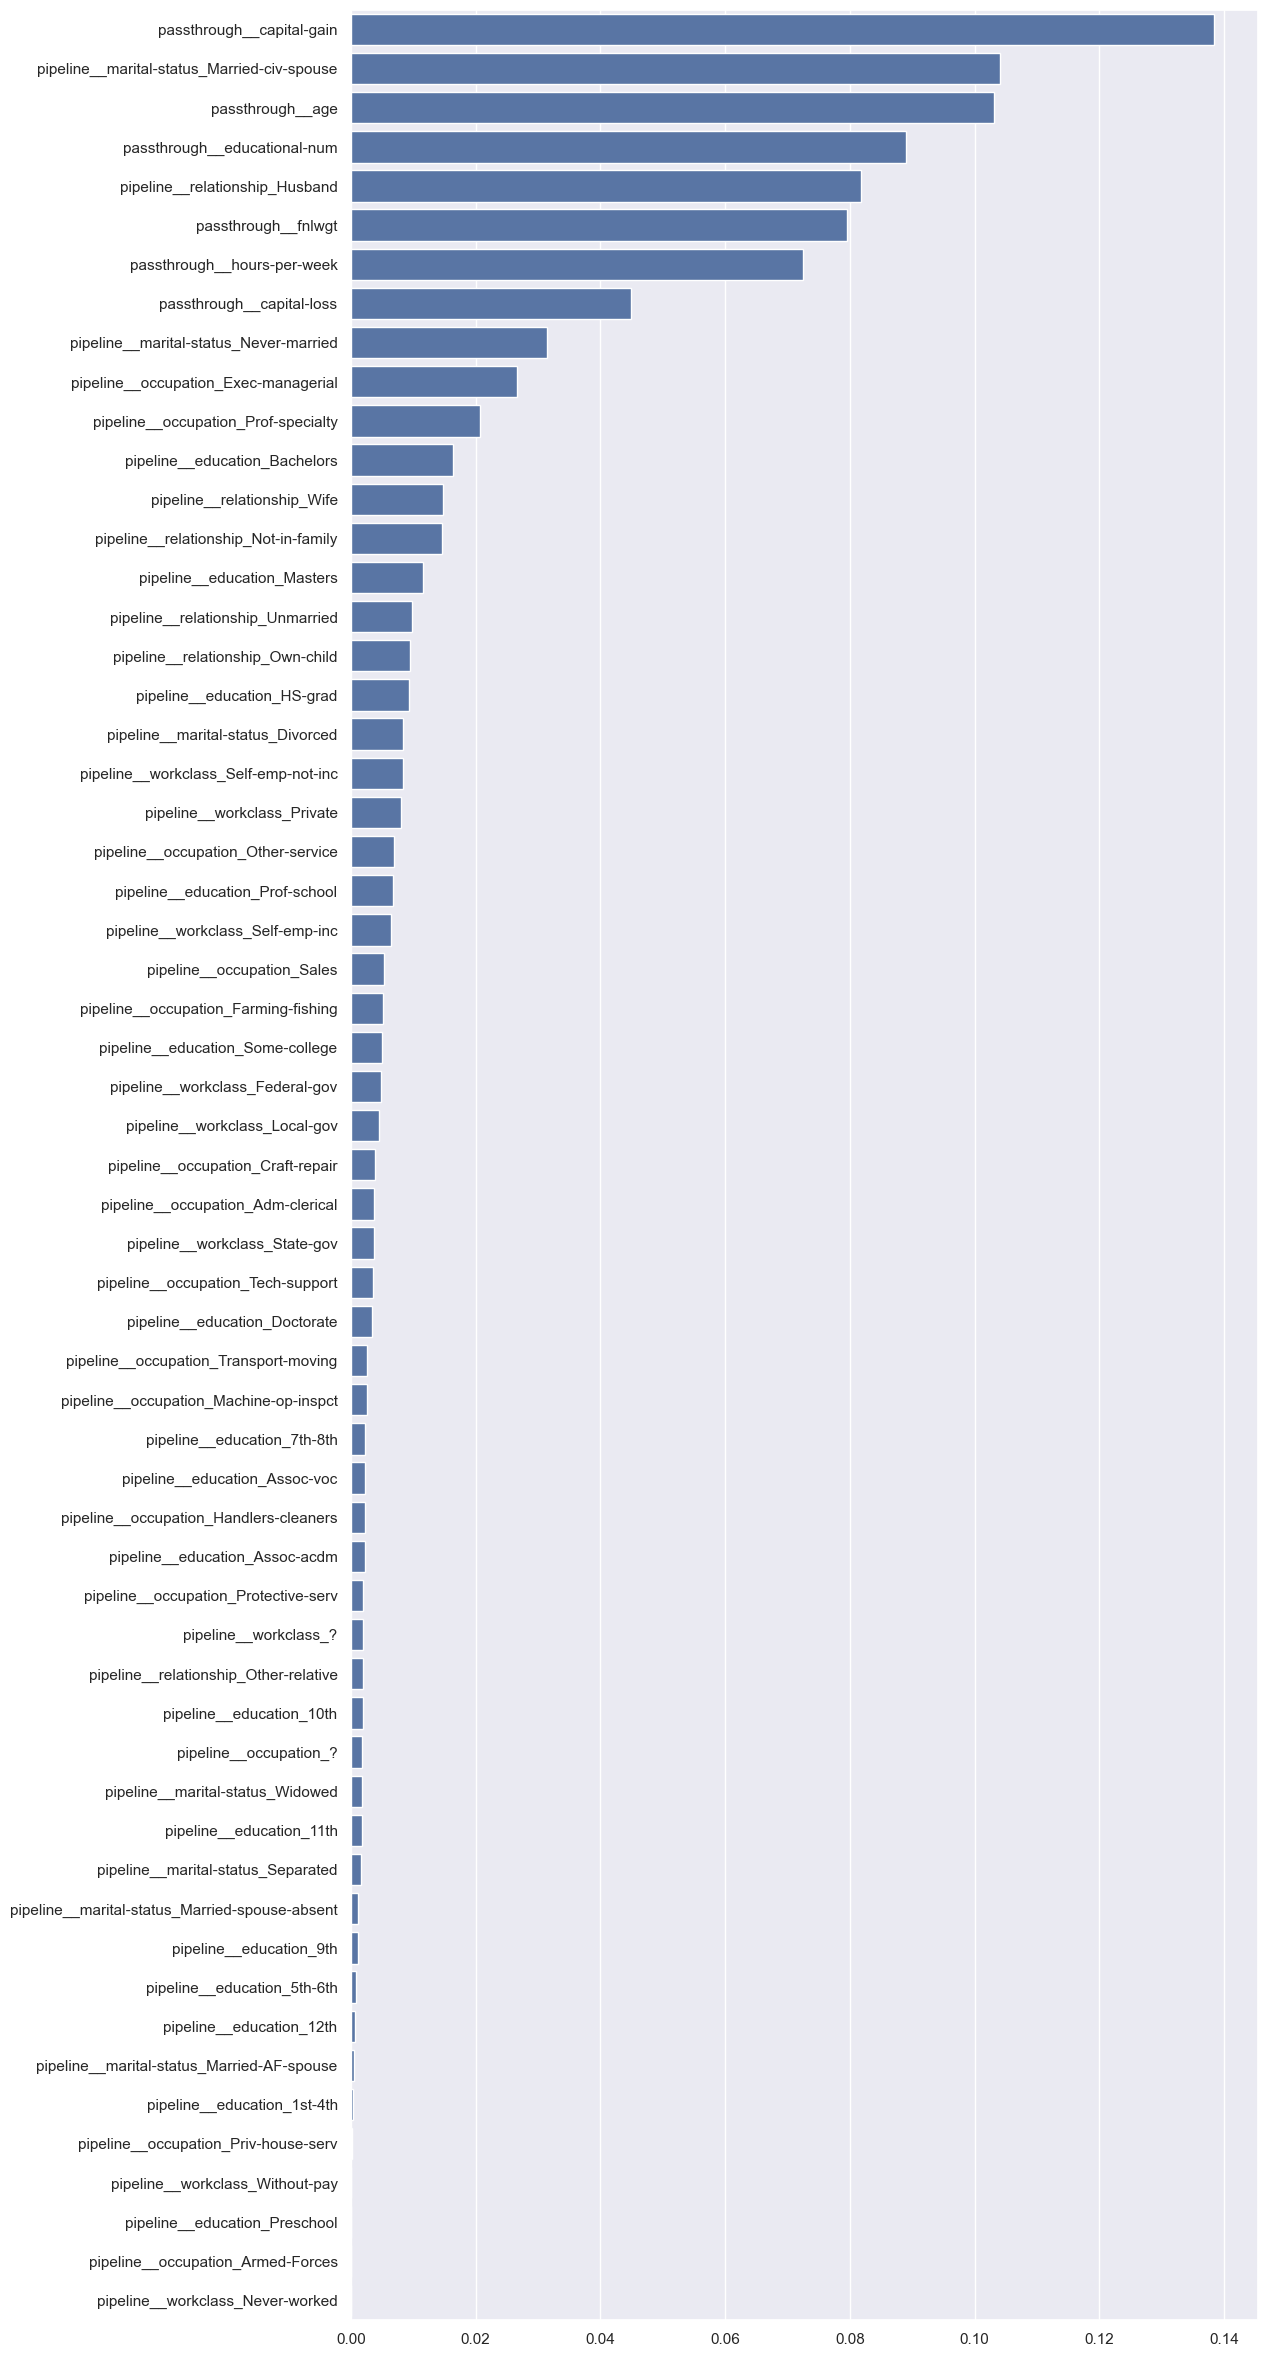

In [62]:
draw_feature_importance(new_clf,new_ct)

## Debiasing techniques: undersampling

As you should have seen when exploring the dataset, the groups of males and females who make more or less than \\$50k are of very different sizes. This alone may have a significant impact on the way the classifier is trained, by teaching it that some groups are much more likely to make more than \\$50k than others.

Let's try to fix this problem by creating a more balanced training set.

#### Question 5
1. Run the cell below to create a new training set by selecting a subset of samples from the original one, in which the groups of males and females who make more or less than \\$50k are of equal size. To use the maximum number of training samples possible, the size of each group should be equal to the size of the smallest of these groups in the original dataset. **What is the size of each group, and of the final training set?**
2. Separate features from target, and transform the cleaned dataset using one-hot encoding. **Remeber to re-transform the test set accordingly!**
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous ones. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Pay particular attention to the difference in results on the training and test set: can you explain these results?
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the previous ones?


In [21]:
# Check the distribution of gender and income
gender_distribution = train_df['gender'].value_counts()
income_distribution = train_df['income'].value_counts()

# Create balanced subsets
balanced_subsets = []
smallest = train_df.shape[0]

# Finding size of smallest subset by gender and income
for gender_category in gender_distribution.index:
    for income_category in income_distribution.index:
        if train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)].shape[0] < smallest:
            smallest = train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)].shape[0]
    
# Sampling subsets 
for gender_category in gender_distribution.index:
    for income_category in income_distribution.index:
        subset = train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)]
        subset = subset.sample(smallest)  # Sample to match the minimum count
        balanced_subsets.append(subset)
        
# Merge the balanced subsets to create the final balanced dataset
balanced_df = pd.concat(balanced_subsets)

In [47]:
#step 2: transformation

X_train_undersampling, y_train_undersampling = (
    balanced_df.drop(columns=["income"]),
    balanced_df["income"],
)

ct_undersampling = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
         categorical_feats,
    ), # OHE on categorical features
    ("passthrough", passthrough_feats) # no transformations on numerical features
)

X_train_under_transformed = ct_undersampling.fit_transform(X_train_undersampling).toarray()

column_names_under = list(
    ct_undersampling.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

X_test_under_transformed = ct_undersampling.transform(X_test).toarray()

#step 3: retrain the classifier

clf_undersampling = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_under_transformed, y_train_undersampling)

In [56]:
#compare
under_train_metrics = fairness_metrics(clf_undersampling, pd.DataFrame(X_train_under_transformed, columns=column_names_under), y_train_undersampling)
under_test_metrics = fairness_metrics(clf_undersampling, pd.DataFrame(X_test_under_transformed, columns=column_names_under), y_test)

results_dict3 = {}
results_dict3 = results_dict2.copy()  
results_dict3["Undersampling Training Set"] = under_train_metrics
results_dict3["Undersampling Test Set"] = under_test_metrics

results_df3 = pd.concat({name: result.set_index('Metric')['Value'] for name, result in results_dict3.items()}, axis=1).T

results_df3

Metric,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,Average Distance from Reference,Accuracy
Training_set,0.172842,0.349042,0.370874,0.101238,0.265089,0.883967,0.642825,0.907046
Testing_set,0.140122,0.281567,0.817173,0.179615,0.357543,1.237044,0.576837,0.861462
Drop characteristics Training Set,0.175075,0.353552,0.279112,0.077174,0.255225,0.853163,0.667783,0.919009
Drop characteristics Test Set,0.150408,0.302237,0.985436,0.232500,0.351786,1.214334,0.531995,0.861530
Undersampling Training Set,0.938392,0.938392,0.236812,0.222222,0.694087,0.742857,0.371206,0.959167
Undersampling Test Set,0.249523,0.501404,1.421018,0.556203,0.252592,0.984092,0.479534,0.801065


<Axes: >

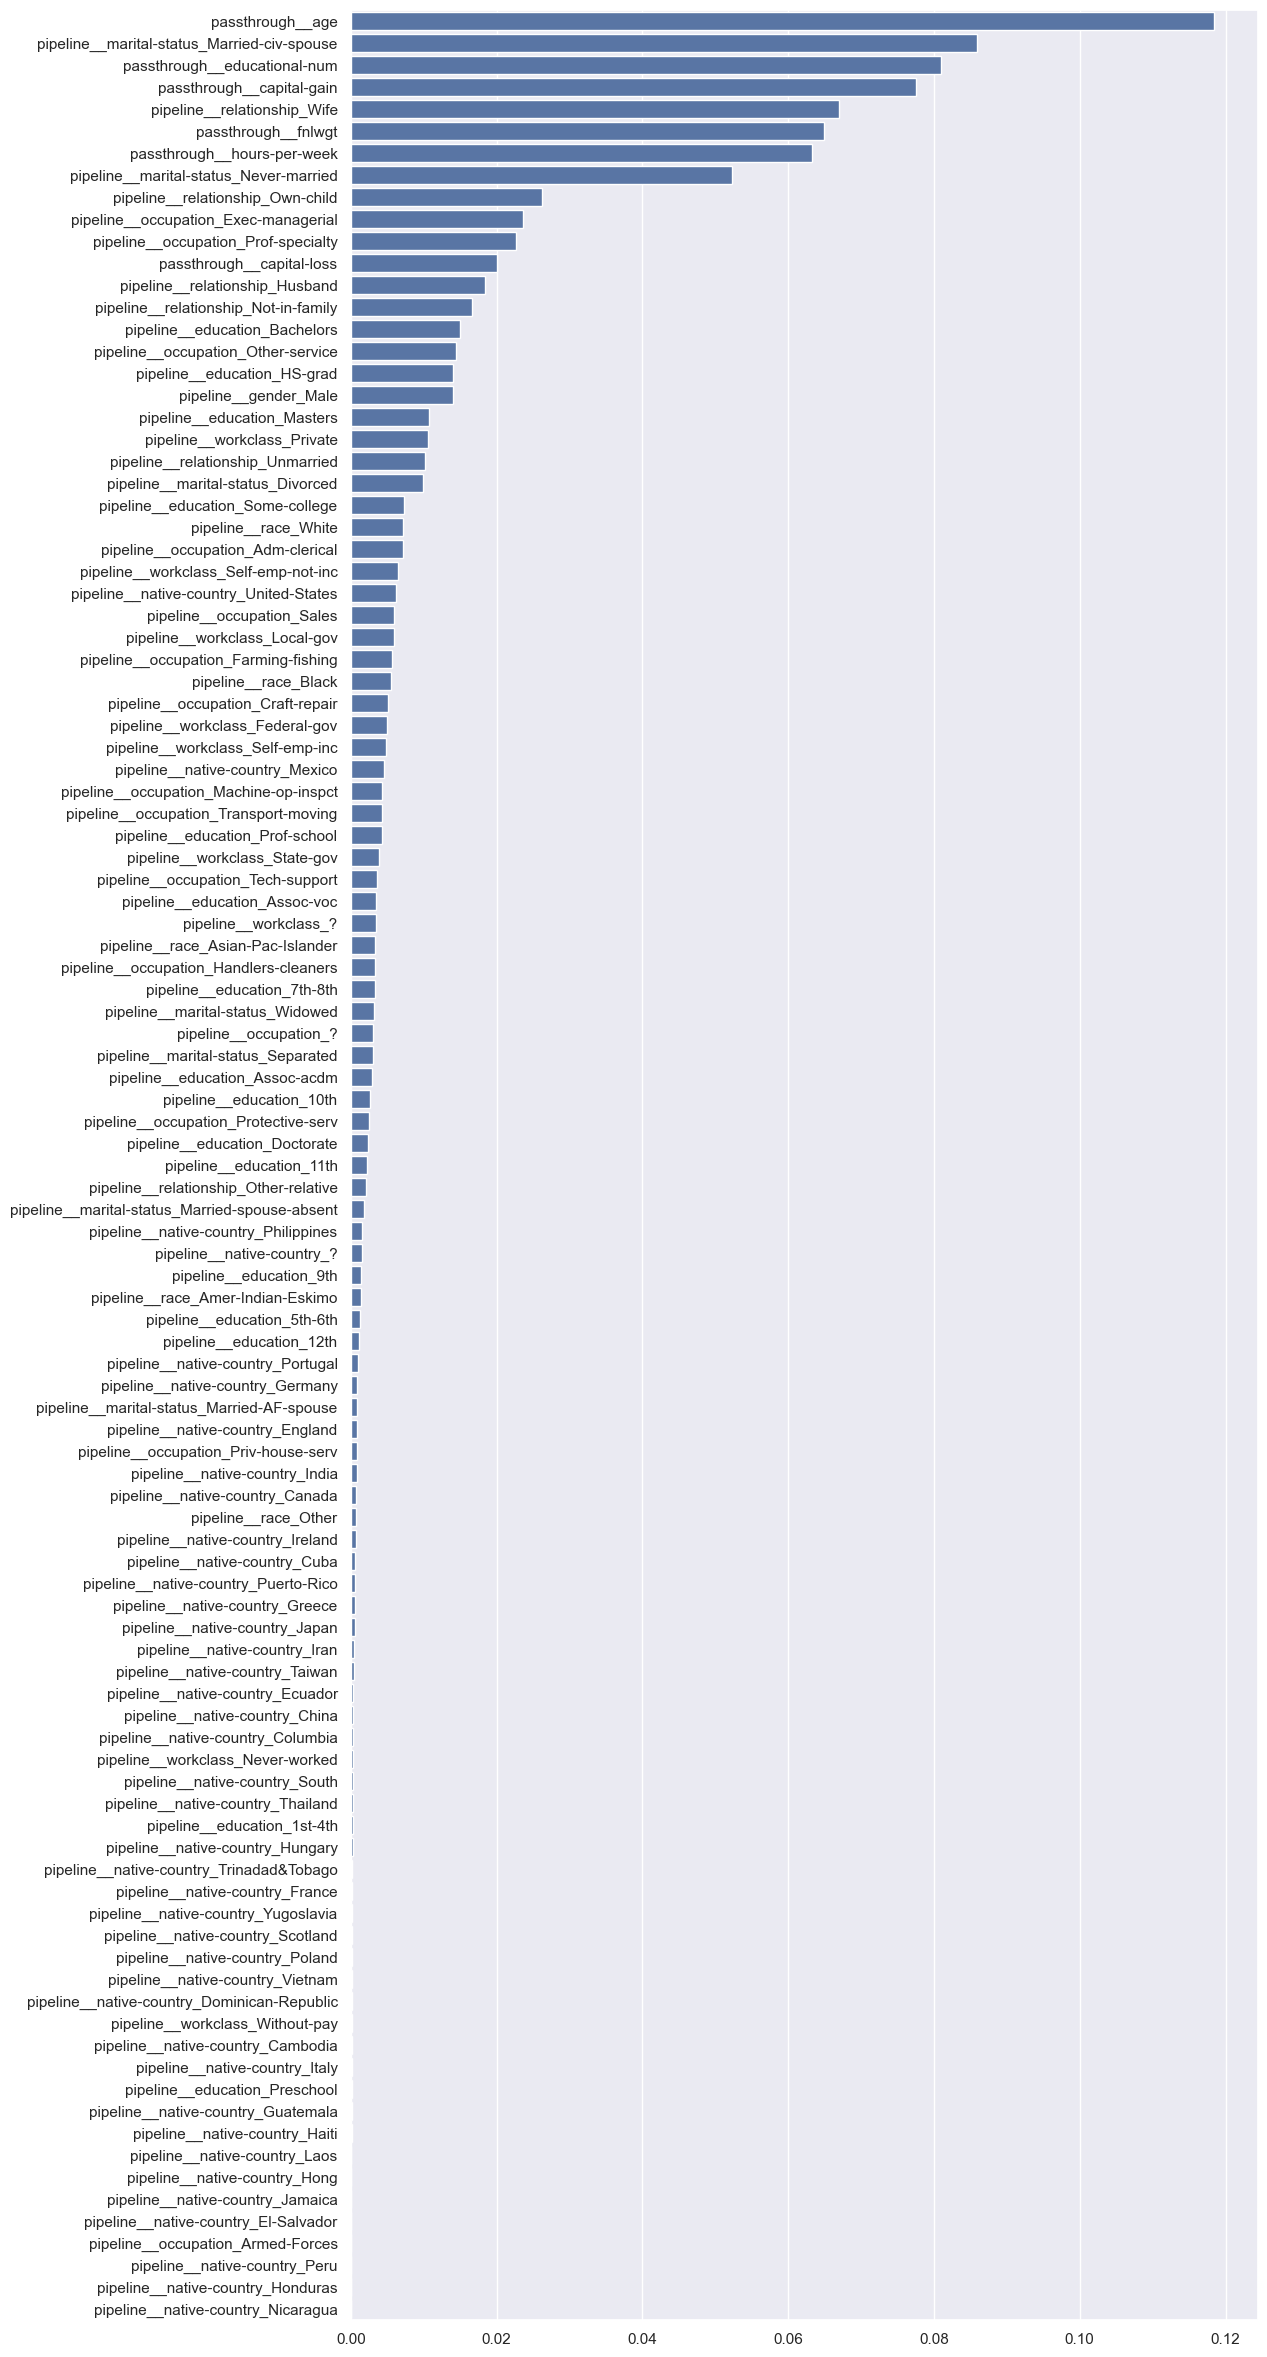

In [61]:
draw_feature_importance(clf_undersampling,ct_undersampling)

1. The size of each group is 1249 and the that of final training set is 4996.

## Debiasing techniques: oversampling (with SMOTE)

Another way to create a more balanced training set, but without sacrificing training samples, is by *oversampling*, which means artificially increasing the size of the training set with "fake" samples. This can be achieved mainly in two ways:
1. By resampling (replicating) samples from the original training set, or
2. By introducing artificial *new* samples, similar enough to those included in the original training set

The Synthetic Minority Oversampling Technique (SMOTE) seen in class falls in the second group. In this portion of the assignment, you will create a more balanced dataset using SMOTE (specifically [SMOTENC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html), a version of SMOTE that allows working with categorical variables).

#### Question 6
1. Run the cell below to create a more balanced training set using SMOTE. Note that a large portion of code is replicated to guarantee that the correct data is used, and not one modified in previous cells. The actual rebalancing all happens in the last 2 lines.
2. Explore the new training set, and provide the following information: what is the size of the new training set? Is the target variable balanced? How many samples are classified as >\\$50, and how many as <=\\$50k? Is the target variable balanced across protected groups, or at least more balanced than before? How many males and females are classified as >\\$50, and how many as <=\\$50k?
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous ones. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Pay particular attention to the difference in results on the training and test set: can you explain these results?
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the previous ones?

In [64]:
from imblearn.over_sampling import SMOTENC

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

oversample = SMOTENC(categorical_features=categorical_feats, random_state=0)

X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)


In [65]:
# Transformation applied after oversampling

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"


ctSMOTE = make_column_transformer(
    (
        OneHotEncoder(handle_unknown="ignore",drop="if_binary",sparse_output=False),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ctSMOTE.fit_transform(X_train_SMOTE)
X_test_transformed = ctSMOTE.transform(X_test)

# Column names, if needed
column_names = list(
    ctSMOTE.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

# X_train_transformed and X_test_transformed can now be used to answer the questions above

In [72]:
X_train_SMOTE["gender"].value_counts()

gender
Male      39925
Female    12043
Name: count, dtype: int64

In [68]:
y_train_SMOTE.value_counts()

income
<=50K    25984
>50K     25984
Name: count, dtype: int64

In [73]:
x2=X_train_SMOTE

x2['income'] = y_train_SMOTE  # Add income back to the features

# Check distribution by gender and income
gender_income_counts = x2.groupby(['gender', 'income']).size().unstack(fill_value=0)

print(gender_income_counts)

income  <=50K   >50K
gender              
Female  10074   1969
Male    15910  24015


Explore the new training set, and provide the following information: what is the size of the new training set? Is the target variable balanced? How many samples are classified as >\\$50, and how many as <=\\$50k? Is the target variable balanced across protected groups, or at least more balanced than before? How many males and females are classified as >\\$50, and how many as <=\\$50k?

In [75]:
print(train_df.groupby(['gender', 'income']).size().unstack(fill_value=0))

income  <=50K  >50K
gender             
Female  10074  1249
Male    15910  6956


The size of training set is 51968. The target variable is balanced. The number of samples that are classified as >$50 is 25984 while that of classified as <=$50 is also 25984. **balanced??** 24015 males and 1969 female are classified as >$50, and 15910 males and 10074 female are classified as <=$50k

## Equalized odd post processing

An alternative to the methods seen so far (which may produce unsatisfactory results), is applying post-processing to the predictions of the classifier, so that they optimize equalized odds (whether the TPR and FPR are on par across groups).

`aif360`, a popular open-source library dedicated to detecting and mitigating bias in machine learning models, includes [`EqOddsPostprocessing`](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.postprocessing.EqOddsPostprocessing.html), a function to performe equalized odds post-processing. The function is slightly more intricate to use than others you have used so far (typically from `sklearn`), so we will see together how to apply it on the test (you may try and replicate this on the training set for your own practice).

In [ ]:
# Run this cell to reset training and test sets (and clear accidental prior changes)

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

In [ ]:
# Run this cell to do the necessary dataset preprocessing (encoding of categorical features).
# Note that, since we are using a tree based classifier, we don't need to scale the 
# numerical features.

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ct.fit_transform(X_train).toarray()
X_test_transformed = ct.transform(X_test).toarray()

In [ ]:
# Convert numpy arrays to pandas dataframes

column_names = list(
    ct.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

X_train_df = pd.DataFrame(X_train_transformed, columns=column_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=column_names)

In [ ]:
# Train RandomForestClassifier
clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_df, y_train)

# Get predictions for test set 
y_pred = clf.predict(X_test_df)

# So far, all this is the same as the biased classifier we started with 

In [ ]:
# Convert test data into a BinaryLabelDataset, necessary to work in aif360

from aif360.datasets import BinaryLabelDataset

X_test_df = X_test_df.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_binary = y_test.map({'>50K': 1, '<=50K': 0})  # Map categorical values to binary

test_bld = BinaryLabelDataset(df=pd.concat([X_test_df, y_binary], axis=1),
                              label_names=['income'],
                              protected_attribute_names=['gender_Male'])

In [ ]:
# Create another dataset with predicted labels for comparison
test_pred_bld = test_bld.copy()

# Convert to binary label (e.g., class 2 is positive, others are negative)
y_pred_binary = np.where(y_pred == '>50K', 1, 0)

test_pred_bld.labels = y_pred_binary.reshape(-1, 1)

In [ ]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

# Initialize EqOddsPostprocessing
eq_odds = EqOddsPostprocessing(unprivileged_groups=[{'gender_Male': 0}],
                               privileged_groups=[{'gender_Male': 1}])


In [ ]:
# Fit the EqOddsPostprocessing model
eq_odds = eq_odds.fit(test_bld, test_pred_bld)

# Get new fair predictions
fair_pred_bld = eq_odds.predict(test_pred_bld)

# Convert predictions back to array
fair_predictions = fair_pred_bld.labels

In [ ]:
fair_predictions_cat = np.where(fair_predictions == 1, '>50K', '<=50K')
fair_predictions_cat 

`fair_predictions_cat` now includes the post-processed predictions, after equalized odds postprocessing. 

#### Question 7

Compute accuracy and fairness of this new predictions, and compare the results to the previous ones. Do we see any improvement? Is this technique more or less effective than the others tried before?

## Final remarks

#### Question 8

Based on the results seen so far, provide an overall evaluation of our debiasing efforts. In particular, try answering the following questions:
1. What do you think was the most successful technique? Which one was the least successful? 
2. If you found that bias still persists after attempting a debiasing strategy, what do you think is the reason? What could be done to fix this problem?

(max 400 words)

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!